In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Vb1oENoZt7ssmJxzBeA7")
project = rf.workspace("truong-jbsna").project("nhan_dien_benh_tren_la_ca_phe")
version = project.version(2)
dataset = version.download("yolov5")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to nhan_dien_benh_tren_la_ca_phe-2 in yolov5pytorch:: 100%|██████████| 6960/6960 [00:01<00:00, 5071.68it/s]


In [21]:
class CFG:
    # classes
    CLASSES = ['sâu vẽ bùa', 'phấn trắng', 'nấm rỉ sắt', 'đốm rong']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)
    FOLDERS = ['train', 'valid', 'test']
    # paths
    CUSTOM_DATASET_DIR = '/content/nhan_dien_benh_tren_la_ca_phe-2'
    OUTPUT_DIR = './'

In [29]:
def count_images_in_folders(cfg):
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif')
    folder_counts = {}

    for folder in cfg.FOLDERS:
        folder_path = os.path.join(cfg.CUSTOM_DATASET_DIR, folder)
        count = 0

        # Walk through subdirectories if dataset is structured by class
        for root, _, files in os.walk(folder_path):
            count += sum(1 for f in files if f.lower().endswith(image_extensions))

        folder_counts[folder] = count

    return folder_counts


In [30]:
counts = count_images_in_folders(CFG)
for folder, count in counts.items():
    print(f"{folder}: {count} images")


train: 2638 images
valid: 686 images
test: 150 images


# Visualize one image

In [4]:
def display_image(image):
    img = Image.open(image)
    plt.imshow(img)

    print('Type: ', type(img), '\n')
    print('Shape: ', np.array(img).shape, '\n')

    plt.axis('off')
    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



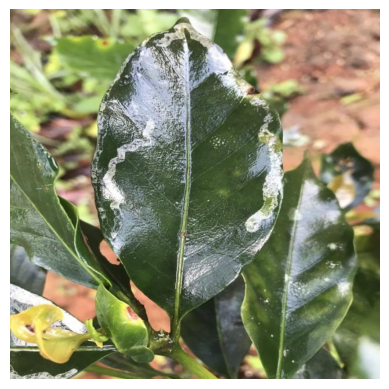

In [5]:
example_image_path = '/content/nhan_dien_benh_tren_la_ca_phe-2/train/images/IMG_2144_1_JPG.rf.aa71afad8a1adc17501cca0fa74d4c48.jpg'
display_image(example_image_path)

# Visualize many images

In [13]:
def plot_random_images_from_folder(folder_path, image_size=(224, 224), num_images=10):
    # Get all image files with supported extensions
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # If not enough images, adjust the number
    if len(image_files) < num_images:
        print(f"Only {len(image_files)} images found in the folder.")
        num_images = len(image_files)

    # Randomly select images
    selected_images = random.sample(image_files, num_images)

    # Set grid layout for plotting
    num_cols = 5  # You can change the number of columns
    num_rows = (num_images + num_cols - 1) // num_cols  # Automatically compute rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    # Flatten axes for easy indexing, in case it's a 2D or 1D array
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i in range(num_rows * num_cols):
        ax = axes[i]
        ax.axis('off')

        if i < num_images:
            file_name = selected_images[i]
            img_path = os.path.join(folder_path, file_name)
            img = Image.open(img_path).convert('RGB')
            img_resized = img.resize(image_size)

            ax.imshow(img_resized)
            #ax.set_title(file_name, fontsize=8)  # Show image filename as title

    plt.tight_layout()
    plt.show()


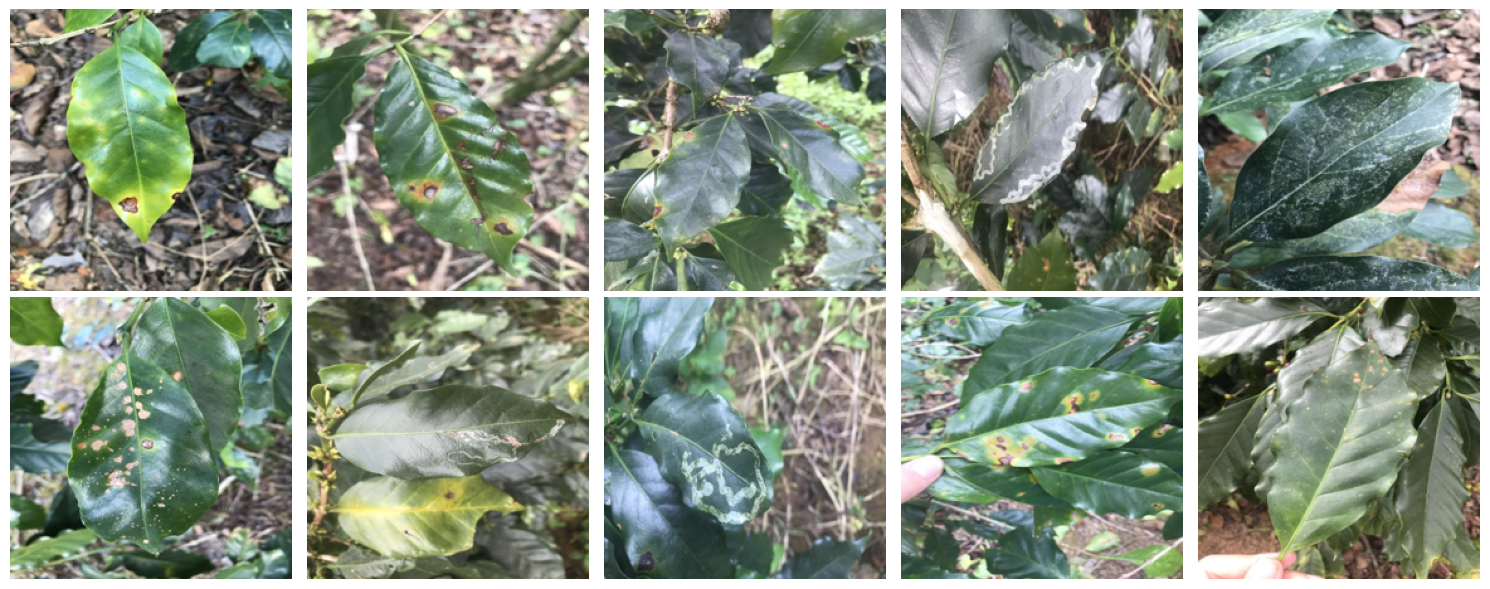

In [14]:
folder_path = '/content/nhan_dien_benh_tren_la_ca_phe-2/train/images'
plot_random_images_from_folder(folder_path, image_size=(224, 224), num_images=10)


# Image properties

In [15]:
def get_image_properties(image_path):
    img = cv2.imread(image_path)

    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [16]:
example_image_path = '/content/nhan_dien_benh_tren_la_ca_phe-2/train/images/IMG_2144_1_JPG.rf.aa71afad8a1adc17501cca0fa74d4c48.jpg'
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

# Dataset statistics

In [22]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

def calculate_statistics(dataset_dir):
    class_info = []

    for mode in CFG.FOLDERS:
        class_count = {cls: 0 for cls in CFG.CLASSES}
        path = os.path.join(dataset_dir, mode, 'labels')

        for file in os.listdir(path):
            with open(os.path.join(path, file)) as f:
                lines = f.readlines()

                for line in lines:
                    cls = line.split()[0]
                    if cls in class_idx:
                        class_count[class_idx[cls]] += 1

        class_info.append({
            'Mode': mode,
            **class_count,
            'Data_Volume': len(os.listdir(path))
        })

    return pd.DataFrame(class_info)


stats_dir = calculate_statistics(CFG.CUSTOM_DATASET_DIR)

combined_stats = pd.concat([stats_dir], ignore_index=True)

mode_order = ['train', 'valid', 'test']

combined_stats['Mode'] = pd.Categorical(combined_stats['Mode'], categories=mode_order, ordered=True)

final_stats = combined_stats.groupby('Mode', as_index=False).sum()

final_stats = final_stats.sort_values('Mode').reset_index(drop=True)

final_stats

,Mode,sâu vẽ bùa,phấn trắng,nấm rỉ sắt,đốm rong,Data_Volume
0,train,690,1055,228,859,2638
1,valid,189,257,64,217,686
2,test,38,59,5,56,150


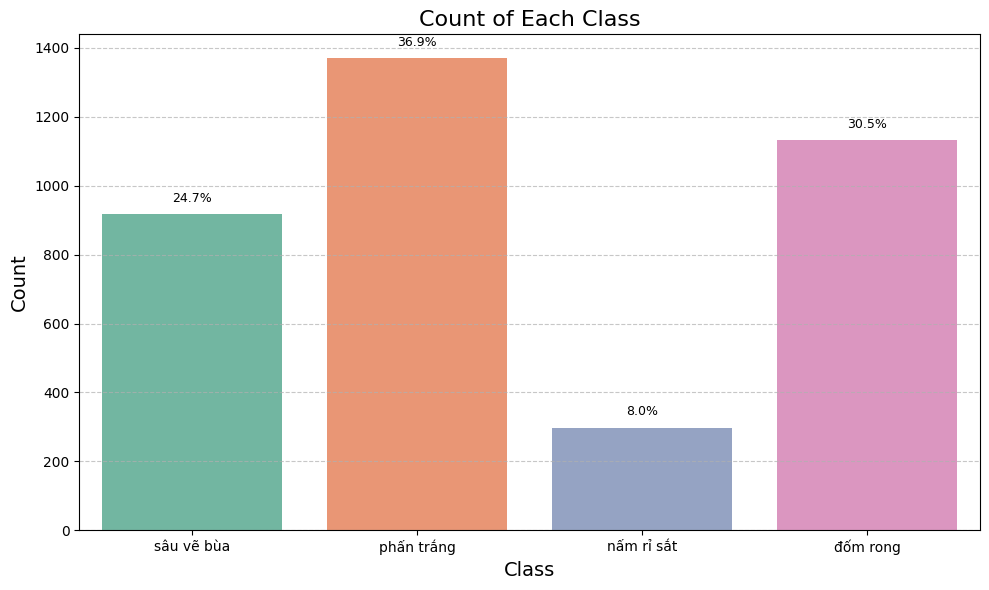

In [23]:
def calculate_statistics(dataset_dir, classes):
    class_data = {cls: 0 for cls in classes}

    for mode in CFG.FOLDERS:
        label_folder = os.path.join(dataset_dir, mode, 'labels')
        if os.path.exists(label_folder):
            for label_file in os.listdir(label_folder):
                if label_file.endswith('.txt'):
                    label_path = os.path.join(label_folder, label_file)
                    with open(label_path, 'r') as f:
                        for line in f:
                            class_id = int(line.split()[0])
                            if class_id < len(classes):
                                class_data[classes[class_id]] += 1

    return pd.DataFrame({'class': list(class_data.keys()), 'count': list(class_data.values())})

stats = calculate_statistics(CFG.CUSTOM_DATASET_DIR, CFG.CLASSES)

total_count_sum = stats['count'].sum()
stats['percentage'] = (stats['count'] / total_count_sum) * 100

plt.figure(figsize=(10, 6))
sns.barplot(
    x='class', y='count', data=stats, palette='Set2'
)

for i, row in stats.iterrows():
    plt.text(
        x=i,
        y=row['count'] + stats['count'].max() * 0.02,
        s=f"{row['percentage']:.1f}%",
        ha='center', va='bottom', fontsize=9, color='black'
    )

plt.title('Count of Each Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

# Image sizes

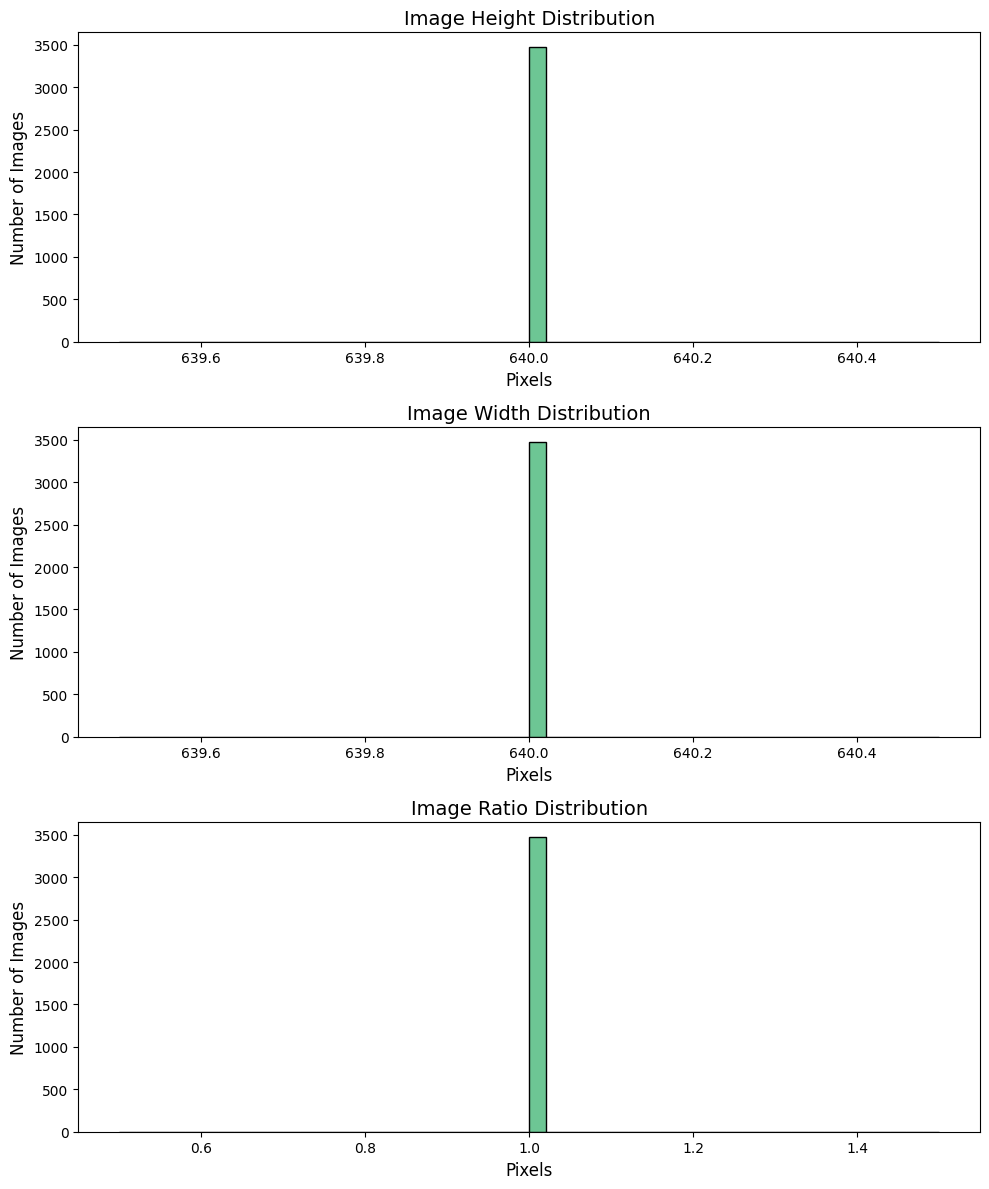

In [25]:
image_heights = []
image_widths = []
image_ratios = []

for dataset_dir in [CFG.CUSTOM_DATASET_DIR]:
    for mode in CFG.FOLDERS:
        image_folder = os.path.join(dataset_dir, mode, 'images')
        if os.path.exists(image_folder):
            for file in os.listdir(image_folder):
                image_path = os.path.join(image_folder, file)
                with Image.open(image_path) as img:
                    width, height = img.size
                    image_widths.append(width)
                    image_heights.append(height)
                    image_ratios.append(width / height)

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

sns.histplot(image_heights, bins=50, kde=False, color='mediumseagreen', ax=axes[0])
axes[0].set_title('Image Height Distribution', fontsize=14)
axes[0].set_xlabel('Pixels', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)

sns.histplot(image_widths, bins=50, kde=False, color='mediumseagreen', ax=axes[1])
axes[1].set_title('Image Width Distribution', fontsize=14)
axes[1].set_xlabel('Pixels', fontsize=12)
axes[1].set_ylabel('Number of Images', fontsize=12)

sns.histplot(image_ratios, bins=50, kde=False, color='mediumseagreen', ax=axes[2])
axes[2].set_title('Image Ratio Distribution', fontsize=14)
axes[2].set_xlabel('Pixels', fontsize=12)
axes[2].set_ylabel('Number of Images', fontsize=12)

plt.tight_layout()
plt.show()

In [26]:
from collections import Counter

most_common_height = Counter(image_heights).most_common(1)[0]
print(f"Most common height: {most_common_height[0]} (appears {most_common_height[1]} times)")

most_common_width = Counter(image_widths).most_common(1)[0]
print(f"Most common width: {most_common_width[0]} (appears {most_common_width[1]} times)")

most_common_ratio = Counter(image_ratios).most_common(1)[0]
print(f"Most common ratio: {most_common_ratio[0]:.2f} (appears {most_common_ratio[1]} times)")

Most common height: 640 (appears 3474 times)
Most common width: 640 (appears 3474 times)
Most common ratio: 1.00 (appears 3474 times)


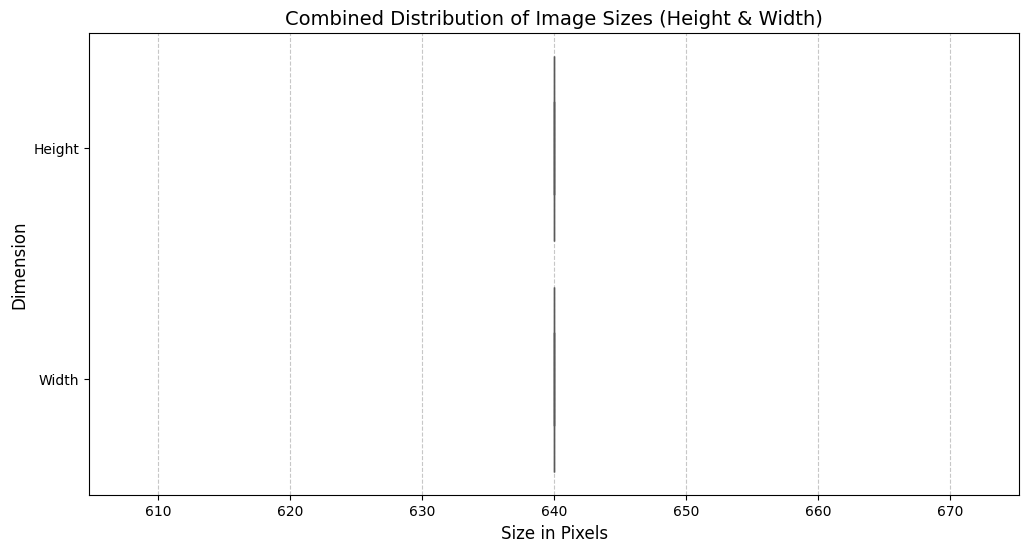

In [27]:
data = {'dimension': [], 'size': []}

for dataset_dir in [CFG.CUSTOM_DATASET_DIR]:
    for mode in CFG.FOLDERS:
        image_folder = os.path.join(dataset_dir, mode, 'images')
        if os.path.exists(image_folder):
            for file in os.listdir(image_folder):
                image_path = os.path.join(image_folder, file)
                with Image.open(image_path) as img:
                    width, height = img.size
                    data['dimension'].extend(['Height', 'Width'])
                    data['size'].extend([height, width])

size_df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
sns.boxplot(x='size', y='dimension', data=size_df, palette='Set2')
plt.title('Combined Distribution of Image Sizes (Height & Width)', fontsize=14)
plt.xlabel('Size in Pixels', fontsize=12)
plt.ylabel('Dimension', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()